### Решение

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

In [29]:
pd.set_option('display.max_columns', 100)

In [30]:
np.random.seed(42)

In [31]:
m = 6
k = 25
n = 130

### 1. Матрица переходных вероятностей

\begin{equation*}
P=
   \begin{pmatrix}
      0.7& 0.3& 0& 0& 0& 0 \\
      0.2& 0.6& 0.2& 0& 0& 0 \\
      0& 0& 0.9& 0.1& 0& 0 \\
      0& 0& 0& 0.7& 0.3& 0 \\
      0& 0& 0& 0& 0.8& 0.2 \\
      0.4& 0& 0& 0& 0& 0.6 \\
   \end{pmatrix}
\end{equation*}

In [32]:
P = np.array([[0.7, 0.3, 0, 0, 0, 0],
              [0.2, 0.6, 0.2, 0, 0, 0],
              [0, 0, 0.9, 0.1, 0, 0],
              [0, 0, 0, 0.7, 0.3, 0],
              [0, 0, 0, 0, 0.8, 0.2],
              [0.4, 0, 0, 0, 0, 0.6]])
print(P)
print(f'Размерность полученной матрицы: {P.shape}')
print(f'Проверим, является ли полученная матрица стохастической: {(P.sum(axis=1)==1).all()}')

[[0.7 0.3 0.  0.  0.  0. ]
 [0.2 0.6 0.2 0.  0.  0. ]
 [0.  0.  0.9 0.1 0.  0. ]
 [0.  0.  0.  0.7 0.3 0. ]
 [0.  0.  0.  0.  0.8 0.2]
 [0.4 0.  0.  0.  0.  0.6]]
Размерность полученной матрицы: (6, 6)
Проверим, является ли полученная матрица стохастической: True


### 2. Размеченный граф Марковской цепи

<img src="Рисунок1.png"/>

### 3.Доказательство эргодичности

In [33]:
def count_zeros(pow : int) -> np.int32:
    return (np.linalg.matrix_power(P, pow).ravel() == 0).sum()
    
count_zeros = np.vectorize(count_zeros)

In [34]:
df = pd.DataFrame()
df['Степень матрицы'] = np.arange(1, 10)
df['Количество нулевых элементов'] = count_zeros(df['Степень матрицы'])
df

,Степень матрицы,Количество нулевых элементов
0,1,23
1,2,17
2,3,11
3,4,5
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0


<AxesSubplot: xlabel='Степень матрицы', ylabel='Количество нулевых элементов'>

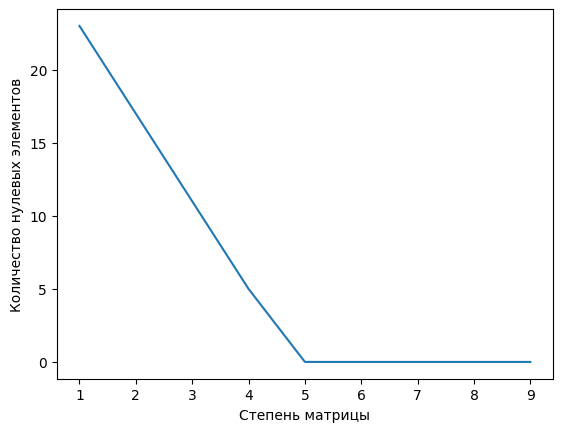

In [35]:
sns.lineplot(df, x='Степень матрицы', y='Количество нулевых элементов')

Так как существует $n_0=5$ такое, что $\min\limits_{i, j}p_{ij}^{(n_0)}>0$, цепь является эргодической.

Выведем $P^5$.

In [36]:
np.round(np.linalg.matrix_power(P, 5), 4).tolist()

[[0.3584, 0.3481, 0.2544, 0.032, 0.0067, 0.0004],
 [0.2326, 0.2423, 0.4017, 0.0848, 0.0343, 0.0043],
 [0.0089, 0.0007, 0.5905, 0.2112, 0.1548, 0.0339],
 [0.1193, 0.0245, 0.0014, 0.1681, 0.4788, 0.2079],
 [0.2935, 0.1111, 0.0173, 0.0005, 0.3277, 0.2499],
 [0.4642, 0.3292, 0.1198, 0.0084, 0.0007, 0.0778]]

### 4. Моделирование вектора начальных вероятностей $p(0)$ согласно приложенному алгоритму

a)Генерируем вектор $\vec{r}$ из независимых и равномерно распределенных на отрезке $[0,1]$ случайных величин;<br>
б)Строим вариационный ряд, сортируя сгенерированный вектор;<br>
в)Находим длины отрезков, на которые вектор $\vec{r}$ разбивает отрезок $[0,1]$ - получаем вектор начальных вероятностей.

In [37]:
r = np.random.random(m-1)
r_series = np.sort(r)
p_0 = np.diff(np.insert(r_series, [0, len(r_series)], [0, 1]))
print(f'Вектор из независимых и равномерно распределенных на отрезке [0,1] случайных величин: {np.round(r, 4).tolist()}')
print(f'Вариационный ряд: {np.round(r_series, 4).tolist()}')
print(f'Вектор начальных вероятностей: {np.round(p_0, 4).tolist()}')

Вектор из независимых и равномерно распределенных на отрезке [0,1] случайных величин: [0.3745, 0.9507, 0.732, 0.5987, 0.156]
Вариационный ряд: [0.156, 0.3745, 0.5987, 0.732, 0.9507]
Вектор начальных вероятностей: [0.156, 0.2185, 0.2241, 0.1333, 0.2187, 0.0493]


### 5. Вычисление безусловных вероятностей состояний цепи через $k$ шагов

$p(k)^T=p(0)^T\cdot P^k,\ k = 10$

In [38]:
p_k = p_0 @ np.linalg.matrix_power(P, k)
p_k

array([0.20349169, 0.15347911, 0.31096943, 0.10356577, 0.15288001,
       0.07561398])

### 6. Моделирование $n$ траекторий полученной цепи за $k$ шагов

In [39]:
num_states = np.zeros(m)
trajectories = []
for i in range(n):
    state = np.argmax(p_0.cumsum()>np.random.random(1))
    trajectory = [state]
    for j in range(k):
        state = np.argmax(P[state].cumsum()>np.random.random(1))
        trajectory.append(state)
    num_states[state]+=1
    trajectories.append(trajectory)

Выведем 3 случайных траектории.

In [46]:
for i in range(3):
    ind = int(np.random.random(1)*len(trajectories))
    print(f'Номер в списке: {ind}\n{trajectories[ind]}')

Номер в списке: 31
[4, 4, 5, 5, 5, 5, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Номер в списке: 72
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Номер в списке: 5
[1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 0, 0, 1, 1, 1, 1]


In [41]:
state_df = pd.DataFrame({'Номер состояния':np.arange(1,7), 'Частота на k-ом шаге' : num_states})
state_df

,Номер состояния,Частота на k-ом шаге
0,1,23.0
1,2,20.0
2,3,39.0
3,4,12.0
4,5,28.0
5,6,8.0


<AxesSubplot: xlabel='Номер состояния', ylabel='Частота на k-ом шаге'>

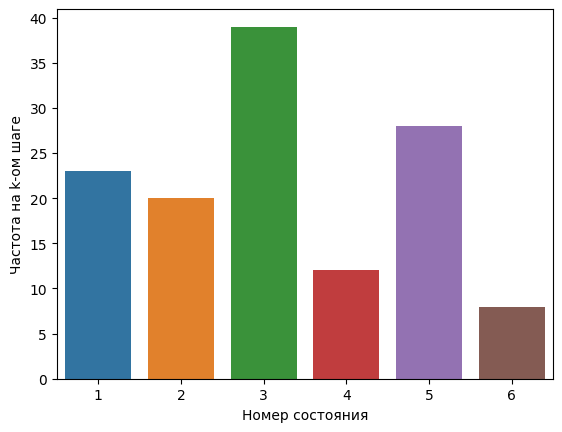

In [42]:
sns.barplot(state_df, x='Номер состояния', y='Частота на k-ом шаге')

### 7. Вычисление эмпирических вероятностей состояний цепи на $k$-ом шаге и сравним их с теоретическими

In [43]:
state_df['Эмпирическая вероятность'] = state_df['Частота на k-ом шаге']/n
state_df['Теоретическая вероятность'] = p_k
state_df

,Номер состояния,Частота на k-ом шаге,Эмпирическая вероятность,Теоретическая вероятность
0,1,23.0,0.176923,0.203492
1,2,20.0,0.153846,0.153479
2,3,39.0,0.300000,0.310969
3,4,12.0,0.092308,0.103566
4,5,28.0,0.215385,0.152880
5,6,8.0,0.061538,0.075614


### 8. Вычисление финальных вероятностей состояний цепи

Для того, чтобы найти финальные вероятности состояний цепи, необходимо решить следующую систему:

\begin{equation*}
  \left\{
    \begin{aligned}
      & p_1 = 0.7p_1+0.2p_2+0.4p_6\\
      & p_2 = 0.3p_1+0.6p_2\\
      & p_3 = 0.2p_2+0.9p_3\\
      & p_4 = 0.1p_3+0.7p_4\\
      & p_5 = 0.3p_4+0.8p_5\\
      & p_6 = 0.2p_5+0.6p_6\\
      & p_1+p_2+p_3+p_4+p_5+p_6=1
    \end{aligned}
  \right.
\end{equation*}

In [44]:
p_final = np.array([0.205128, 0.15384, 0.307692, 0.102564, 0.153846, 0.0769231])
state_df['Финальная вероятность'] = p_final
state_df[['Эмпирическая вероятность', 'Теоретическая вероятность', 'Финальная вероятность']]

,Эмпирическая вероятность,Теоретическая вероятность,Финальная вероятность
0,0.176923,0.203492,0.205128
1,0.153846,0.153479,0.153840
2,0.300000,0.310969,0.307692
3,0.092308,0.103566,0.102564
4,0.215385,0.152880,0.153846
5,0.061538,0.075614,0.076923


### Выводы

При относитнльно большом количестве $n=130$ смоделированных траекторий, эмпирические вероятности состояний цепи близки к теоретическим. Кроме того, теоретические вероятности слабо отличаются от финальных. Таким образом, мы проверили эргодичность системы.